# TOI 519.01 TESS light curve analysis

**Hannu Parviainen**

**Last changed: 16.3.2020**

Here we carry out an initial TESS light curve analysis. We allow for unconstrained flux contamination to see how much a single-colour light curve can constrain it.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import xarray as xa
import pandas as pd
from astropy.table import Table
import astropy.units as u

from pytransit import BaseLPF
from pytransit.param import ParameterSet, GParameter, NormalPrior as NP, UniformPrior as UP
from pytransit.utils.misc import fold
from pytransit.lpf.tesslpf import downsample_time
%run toi_519.py

In [8]:
import pytransit.contamination as cn
from ldtk import tess

In [9]:
def calculate_beaming_alpha(teff: int = 3300):
    spfile = Path(cn.__file__).parent / 'data' / 'spectra.h5'
    spectra = pd.read_hdf(spfile)
    spectrum = spectra[teff]
    wl_nm = spectrum.index.values
    wl = wl_nm * 1e-9
    fl = spectrum.values

    b = 5 + diff(log(fl)) / diff(log(wl))
    w = tess(wl_nm)[1:] * wl[1:] * fl[1:]
    return sum(w * b) / sum(w)

In [10]:
rc('figure', figsize=(13,4))

In [11]:
times, fluxes, _, _, _, _ = read_tess(tess_file, zero_epoch, period, use_pdc=True, baseline_duration_d=period)
phase, time, flux = [], [], []
for t,f in zip(times, fluxes):
    ph = (fold(t, period.n, zero_epoch.n, 0.5) - 0.5) * period.n
    mask = abs(ph) > 0.03
    
    dt = (20 * u.min).to(u.day).value
    bt, bf, _ = downsample_time(t[mask], f[mask], dt)
    bt, bp, _ = downsample_time(t[mask], ph[mask], dt)
    m = isfinite(bt)
    
    phase.append(bp[m])
    time.append(bt[m])
    flux.append(bf[m])

In [12]:
from astropy.constants import c, G
import astropy.units as u

mj2kg = u.M_jup.to(u.kg)
ms2kg = u.M_sun.to(u.kg)
d2s = u.day.to(u.s)

def boosting_amplitude(mp, ms, period, alpha):
    """
    mp: float or ndarray
        Planetary mass [MJup]
    ms: float or ndarray
        Stellar mass [MSun]
    period: float or ndarray
        Orbital period [d]
    alpha: float or ndarray
        Doppler boosting alpha [-]
    """
    return alpha / c.value *(2*pi*G.value/(d2s*period))**(1/3) * ((mp*mj2kg)/(ms*ms2kg)**(2/3))

def ev_amplitude(mp, ms, a, u=0.55, g=0.3):
    ae = 0.15 * (15 + u) * (1 + g) / (3 - g)
    return ae * (mp*mj2kg)/(ms*ms2kg) * a**-3

In [15]:
class LPF(BaseLPF):
    
    def _post_initialisation(self):
        self.t0 = 2458491.8771169
        self.period = 1.2652328
        self.phase = fold(self.timea, self.period, self.t0)
        self._dbf = sin(2*pi*self.phase)
        self._evf = -cos(4*pi*self.phase)
    
    def _init_parameters(self):
        self.ps = ParameterSet()
        porbit = [
            GParameter('mp',  'log10 planet mass',      'MJup',   UP(log10(0.1), log10(300)),  (0,    inf)),
            GParameter('ms',  'Star mass',        'MSun',   NP(1.0, 0.1), (0,    inf))]
        self.ps.add_global_block('orbit', porbit)
        
        pbl = [GParameter(f'c{i:02d}', f'baseline {i:02d}', '', NP(1.0, 0.005), (0, inf)) for i in range(len(self.times))]
        self.ps.add_global_block('baseline', pbl)
        self._sl_bl = self.ps.blocks[-1].slice
        self.ps.freeze()

    def baseline(self, pv):
        pv = atleast_2d(pv)
        return squeeze(pv[:, self._sl_bl][:, self.lcids])
        
    def boosting(self, pv):
        pv = atleast_2d(pv)
        a = boosting_amplitude(10**pv[:,0:1], pv[:,1:2], self.period, alpha=8.5)
        return squeeze(a * self._dbf)
    
    def ellipsoidal_variation(self, pv):
        pv = atleast_2d(pv)
        a = ev_amplitude(10**pv[:,0:1], pv[:,1:2], 10, 0.55, 0.3)
        return squeeze(a * self._evf)
        
    def phase_model(self, pv):
        pv = atleast_2d(pv)
        return squeeze(self.ellipsoidal_variation(pv) + self.boosting(pv))
        
    def flux_model(self, pv):
        pv = atleast_2d(pv)
        return squeeze(self.baseline(pv) + self.phase_model(pv))
    
    def create_pv_population(self, npop: int = 50):
        return self.ps.sample_from_prior(npop)

In [16]:
lpf = LPF('toi_519_boosting', ['TESS'], time, flux, wnids=arange(len(flux)))
lpf.set_prior('ms', 'NP', star_m.n, star_m.s)

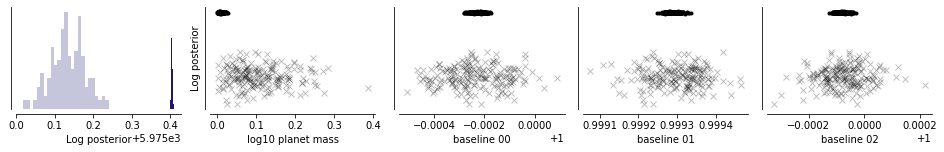

In [23]:
lpf.optimize_global(200, npop=200)

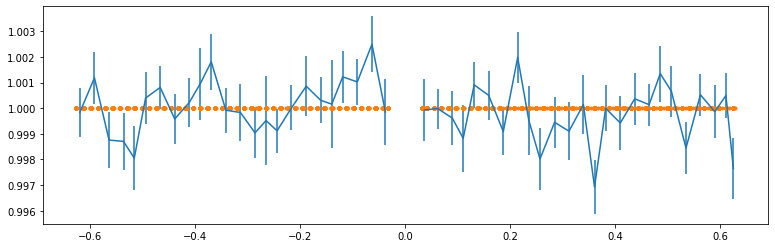

In [24]:
phasea = concatenate(phase)
sids = argsort(phasea)
bp, bf, be = downsample_time(phasea[sids], (lpf.ofluxa-lpf.baseline(lpf.de.minimum_location)+1)[sids], 0.025)
errorbar(bp, bf, be)
plot(phasea, 1+lpf.phase_model(lpf.de.minimum_location), '.')

In [43]:
lpf.sample_mcmc(5000, thin=30, repeats=1)

In [81]:
adb = boosting_amplitude(10**df.mp.values, df.ms.values, lpf.period, 8.5)

In [86]:
K = (adb / 8.5 * c.value / 1000)

In [87]:
percentile(K, [90,99])

array([4.26393378, 9.60837544])

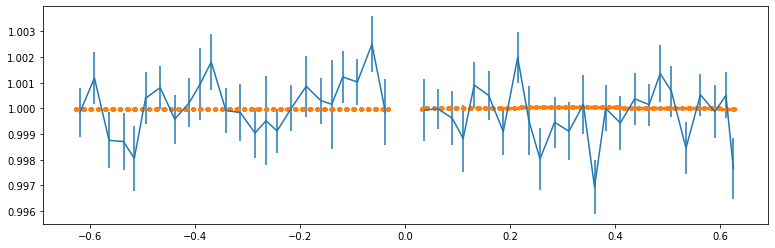

In [44]:
df = lpf.posterior_samples(derived_parameters=False)
pv = df.median().values

phasea = concatenate(phase)
sids = argsort(phasea)
bp, bf, be = downsample_time(phasea[sids], (lpf.ofluxa-lpf.baseline(pv)+1)[sids], 0.025)
errorbar(bp, bf, be)
plot(phasea, 1+lpf.phase_model(pv), '.')

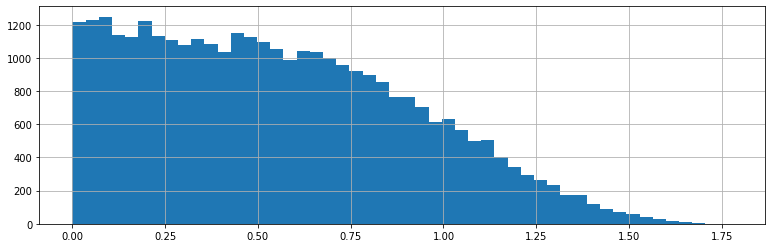

In [80]:
(df.mp).hist(bins=50)

array([ 3.28758305, 11.64894652, 26.0742582 ])

In [47]:
import seaborn as sb

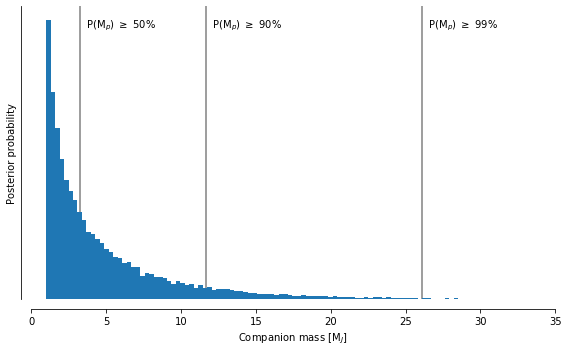

In [73]:
fig, ax = subplots(figsize=(8,5))
hist(10**df.mp, bins=100, range=(0.1,30))
ps = [50, 90, 99]
pers = percentile(10**df.mp, ps)
[ax.axvline(v, c='k', alpha=0.5, zorder=-10) for v in pers]
[ax.text(v, 3800, f"  P(M$_p$) $\geq$ {p:2d}%") for v,p in zip(pers,ps)]
setp(ax, xlim=(0,35), yticks=[], ylabel='Posterior probability', xlabel='Companion mass [M$_J$]')
sb.despine(fig, offset=10)
fig.tight_layout()
fig.savefig('toi_519_mass_from_phase_variations.pdf')

In [16]:
lpf.save()

---

<center> © 2020 Hannu Parviainen </center>